In [23]:
from ds_utils.ds_preamble import *
from ds_utils.ds_helper import *
from ds_utils.ds_plotting import *
from glob import glob
import re
import datetime
import duckdb
import pathlib
# from ds_utils.ds_preamble import *  # # self-defined module
# from ds_utils.ds_helper import *  # self-defined module
# from ds_utils.ds_plotting import *  # # self-defined module


tips = sns.load_dataset('tips')
tips_tiny = tips.sample(20)

df = tips 

titanic = sns.load_dataset('titanic')

np.random.seed(123)
tips['decile'] = np.random.randint(1,4, size=len(tips))

train = tips.sample(frac=0.7, random_state=30).reset_index(drop=True)
test = tips.drop(train.index).reset_index(drop=True)

## add a multiple of the mean of the corresponding size to each entry, so that mean(size[i]) = i * mean(size[1])

In [127]:
# we use a loop to do it...
threshold=0.08
means = tips.groupby('size').total_bill.mean()
means

res = {}
for size in range(2,7):
    data = tips.query(f'size=={size}').total_bill
    target = size*means[1]
    for i in np.arange(-1, 3, 0.001):
        data_inflate = data.add(i*means[size]).mean()
        if abs(data_inflate - target)<=0.08:
            # print(size)
            res[size] = [i, data_inflate]
            break
    if size not in res:
        # print(f'in else: {size}')
        res[size] = np.nan
res

size
1     7.242500
2    16.448013
3    23.277632
4    28.613514
5    30.068000
6    34.830000
Name: total_bill, dtype: float64

{2: [-0.12399999999999922, 14.408459230769244],
 3: [-0.06999999999999917, 21.64819736842107],
 4: [0.010000000000000897, 28.89964864864868],
 5: [0.20200000000000107, 36.14173600000004],
 6: [0.2460000000000011, 43.39818000000004]}

## duplicate records: the idea comes from needing to duplicate `decline` records to make them have total exposure = 5
- we can use `pd.Index.repeat()`

In [4]:
tips_tiny = tips_tiny[:5].reset_index(drop=True)
template = tips_tiny.iloc[[0]].copy()

# case 1: duplicate a portion of the frame
# M1
tips.loc[tips.index.append(tips.query("size==6").index.repeat(2))].reset_index(drop=True)
# M2
pd.concat([tips] + [tips.query("size==6")]*2, ignore_index=True)

# case 2: duplicate entire frame
# M1
tips.loc[tips.index.repeat(3)].reset_index()
# M2
t = pd.concat([tips]*3, ignore_index=True)

# case 3: duplicate a portion, and increase the feature value
# ex: for those records with size==6, want to duplicate their records 2 times, and then increase their tip and total_bill by 1 each 

# M1: bad. use for loop
# indices = tips.query("size==6").index
# print(indices)
# tips.loc[indices]

# df_new = tips.loc[tips.index.append(indices.repeat(3))]

# for idx in indices:
#     for feature in ['tip','total_bill']:
#         subset = df_new.loc[idx, feature]
#         base_val = subset.iloc[0]
#         df_new.loc[idx, feature] = np.arange(base_val, base_val + len(subset))

# df_new.loc[indices]


# M2: use groupby
def f(df):
    for feat in ['total_bill', 'tip', 'size']:
        base_val = df[feat].min()
        if feat == 'size':
            df[feat] = [base_val] + [0]*(len(df)-1)
        else:
            df[feat] = np.arange(base_val, base_val + len(df))
    return df 

df_repeat = tips.loc[tips.query("size==6").index.repeat(5)]
df_done = df_repeat.groupby(df_repeat.index).apply(f)
df_done

pd.concat([tips.query("size!=6"), df_done], ignore_index=True)

# data_temp_5y <- do.call("rbind", replicate(5, data_temp, simplify = FALSE)) %>%
#   group_by(contract_no) %>%
#   mutate(year_seq = 1:5,
#          contract_year = 1:5,
#          first_year = ifelse(year_seq == 1, 1, 0)) %>%
#   ungroup() %>%
#   arrange(contract_no)



,total_bill,tip,sex,smoker,day,time,size,decile
0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,10.34,1.66,Male,No,Sun,Dinner,3,2
2,21.01,3.50,Male,No,Sun,Dinner,3,3
3,23.68,3.31,Male,No,Sun,Dinner,2,3
4,24.59,3.61,Female,No,Sun,Dinner,4,1
...,...,...,...,...,...,...,...,...
247,34.30,6.70,Male,No,Thur,Lunch,6,1
248,27.05,5.00,Female,No,Thur,Lunch,6,2
249,27.05,5.00,Female,No,Thur,Lunch,6,2
250,48.17,5.00,Male,No,Sun,Dinner,6,3


,total_bill,tip,sex,smoker,day,time,size,decile
0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,10.34,1.66,Male,No,Sun,Dinner,3,2
2,21.01,3.50,Male,No,Sun,Dinner,3,3
3,23.68,3.31,Male,No,Sun,Dinner,2,3
4,24.59,3.61,Female,No,Sun,Dinner,4,1
...,...,...,...,...,...,...,...,...
247,48.17,5.00,Male,No,Sun,Dinner,6,3
248,29.80,4.20,Female,No,Thur,Lunch,6,2
249,34.30,6.70,Male,No,Thur,Lunch,6,1
250,27.05,5.00,Female,No,Thur,Lunch,6,2


,index,total_bill,tip,sex,smoker,day,time,size,decile
0,0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,0,16.99,1.01,Female,No,Sun,Dinner,2,3
2,0,16.99,1.01,Female,No,Sun,Dinner,2,3
3,1,10.34,1.66,Male,No,Sun,Dinner,3,2
4,1,10.34,1.66,Male,No,Sun,Dinner,3,2
...,...,...,...,...,...,...,...,...,...
727,242,17.82,1.75,Male,No,Sat,Dinner,2,2
728,242,17.82,1.75,Male,No,Sat,Dinner,2,2
729,243,18.78,3.00,Female,No,Thur,Dinner,2,2
730,243,18.78,3.00,Female,No,Thur,Dinner,2,2


,total_bill,tip,sex,smoker,day,time,size,decile
125,29.80,4.2,Female,No,Thur,Lunch,6,2
125,30.80,5.2,Female,No,Thur,Lunch,0,2
125,31.80,6.2,Female,No,Thur,Lunch,0,2
125,32.80,7.2,Female,No,Thur,Lunch,0,2
125,33.80,8.2,Female,No,Thur,Lunch,0,2
141,34.30,6.7,Male,No,Thur,Lunch,6,1
141,35.30,7.7,Male,No,Thur,Lunch,0,1
141,36.30,8.7,Male,No,Thur,Lunch,0,1
141,37.30,9.7,Male,No,Thur,Lunch,0,1
141,38.30,10.7,Male,No,Thur,Lunch,0,1


,total_bill,tip,sex,smoker,day,time,size,decile
0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,10.34,1.66,Male,No,Sun,Dinner,3,2
2,21.01,3.50,Male,No,Sun,Dinner,3,3
3,23.68,3.31,Male,No,Sun,Dinner,2,3
4,24.59,3.61,Female,No,Sun,Dinner,4,1
...,...,...,...,...,...,...,...,...
255,48.17,5.00,Male,No,Sun,Dinner,6,3
256,49.17,6.00,Male,No,Sun,Dinner,0,3
257,50.17,7.00,Male,No,Sun,Dinner,0,3
258,51.17,8.00,Male,No,Sun,Dinner,0,3


## standardization by group

In [7]:
tips.groupby('sex').apply(lambda df: df.total_bill + df.total_bill.mean())

tips.select_dtypes('number').groupby(tips.sex).transform(lambda s: (s - s.mean())/s.std()) # same as using `apply`, but `transform` will pass column by column

# bad method: we don't need to calculate the mean separately if the mean can be obtained from the same dataframe!
gp_mean = tips.groupby('sex')[['total_bill','tip']].mean()
tips.groupby('sex')[['total_bill','tip']].apply(lambda df: df-gp_mean.loc[df.name])

# standardization of test set from train set 
# in this case, we need to calculate the mean from train set first 
gp_mean = train.groupby('sex')[['total_bill','tip']].mean()
gp_mean
gp_mean.loc['Male']
test.groupby('sex')[['total_bill','tip']].apply(lambda df: df - gp_mean.loc[df.name])

sex        
Male    1      31.084076
        2      41.754076
        3      44.424076
        5      46.034076
        6      29.514076
                 ...    
Female  226    28.146897
        229    40.176897
        238    53.886897
        240    45.236897
        243    36.836897
Name: total_bill, Length: 244, dtype: float64

,total_bill,tip,size,decile
0,-0.133209,-1.572623,-0.490346,1.275695
1,-1.125195,-0.960054,0.386431,-0.112078
2,0.028759,0.275590,0.386431,1.144792
3,0.317518,0.147997,-0.659597,1.144792
4,0.815699,0.669733,1.642659,-1.163546
...,...,...,...,...
239,0.896118,1.900731,0.386431,1.144792
240,1.139077,-0.718803,-0.490346,-1.163546
241,0.208287,-0.731728,-0.659597,1.144792
242,-0.316237,-0.899615,-0.659597,-0.112078


,total_bill,tip
0,-1.066897,-1.823448
1,-10.404076,-1.429618
2,0.265924,0.410382
3,2.935924,0.220382
4,6.533103,0.776552
...,...,...
239,8.285924,2.830382
240,9.123103,-0.833448
241,1.925924,-1.089618
242,-2.924076,-1.339618


,total_bill,tip
sex,,
Male,20.548679,3.110094
Female,17.473692,2.757385


total_bill    20.548679
tip            3.110094
Name: Male, dtype: float64

,total_bill,tip
0,-4.738679,0.049906
1,-13.298679,2.039906
2,11.301321,0.069906
3,-3.728679,0.889906
4,12.351321,-0.000094
...,...,...
68,8.481321,2.809906
69,9.706308,-0.757385
70,2.121321,-1.110094
71,-2.728679,-1.360094


## reverse columns

In [29]:
tips.set_index('sex').groupby('sex').mean() # case 0: index already has name => just use the index name to group
tips.set_index('sex').rename_axis(index='my_idx').groupby('my_idx').mean() # case 1: suppose index doesn't have a name. Then use `rename_axis` to give it a name first
tips.groupby(lambda idx: idx).mean() # case 2: index doesn't have a name and not use rename_axis => give a dummy identity function, which will be applied to each index value 
tips.groupby(lambda idx: idx%2).mean() # group by even/odd index 

,total_bill,tip,size,decile
sex,,,,
Male,20.744076,3.089618,2.630573,2.089172
Female,18.056897,2.833448,2.459770,1.954023


,total_bill,tip,size,decile
my_idx,,,,
Male,20.744076,3.089618,2.630573,2.089172
Female,18.056897,2.833448,2.459770,1.954023


,total_bill,tip,size,decile
0,16.99,1.01,2.0,3.0
1,10.34,1.66,3.0,2.0
2,21.01,3.50,3.0,3.0
3,23.68,3.31,2.0,3.0
4,24.59,3.61,4.0,1.0
...,...,...,...,...
239,29.03,5.92,3.0,3.0
240,27.18,2.00,2.0,1.0
241,22.67,2.00,2.0,3.0
242,17.82,1.75,2.0,2.0


,total_bill,tip,size,decile
0,19.568852,2.931967,2.450820,2.008197
1,20.003033,3.064590,2.688525,2.073770


In [13]:
tips.query("index>=5")

,total_bill,tip,sex,smoker,day,time,size,decile
5,25.29,4.71,Male,No,Sun,Dinner,4,3
6,8.77,2.00,Male,No,Sun,Dinner,2,3
7,26.88,3.12,Male,No,Sun,Dinner,4,2
8,15.04,1.96,Male,No,Sun,Dinner,2,3
9,14.78,3.23,Male,No,Sun,Dinner,2,2
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,3
242,17.82,1.75,Male,No,Sat,Dinner,2,2


In [10]:
tips.loc[:, ::-1] # M1 
tips[reversed(tips.columns)].head() # M2
tips.columns.str.split(' ', expand=True)
# tips.name.str.split(' ', expand=True)
# zip(*tips.name.str.split(' '))

,decile,size,time,day,smoker,sex,tip,total_bill
0,3,2,Dinner,Sun,No,Female,1.01,16.99
1,2,3,Dinner,Sun,No,Male,1.66,10.34
2,3,3,Dinner,Sun,No,Male,3.50,21.01
3,3,2,Dinner,Sun,No,Male,3.31,23.68
4,1,4,Dinner,Sun,No,Female,3.61,24.59
...,...,...,...,...,...,...,...,...
239,3,3,Dinner,Sat,No,Male,5.92,29.03
240,1,2,Dinner,Sat,Yes,Female,2.00,27.18
241,3,2,Dinner,Sat,Yes,Male,2.00,22.67
242,2,2,Dinner,Sat,No,Male,1.75,17.82


,decile,size,time,day,smoker,sex,tip,total_bill
0,3,2,Dinner,Sun,No,Female,1.01,16.99
1,2,3,Dinner,Sun,No,Male,1.66,10.34
2,3,3,Dinner,Sun,No,Male,3.50,21.01
3,3,2,Dinner,Sun,No,Male,3.31,23.68
4,1,4,Dinner,Sun,No,Female,3.61,24.59


Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size', 'decile'], dtype='object')

## combine two datasets vertically, and create a flag specifying where each dataset is from

In [ ]:
# do not use `ignore_index` and `keys` together. Otherwise, `key` will be ignored. 

# M1: good
pd.concat([train,test], keys=[1,0]).reset_index(level=0).rename({'level_0': 'train'}, axis=1).reset_index(drop=True) 

# M2: bad
train['train'] = 1
test['train'] = 0
pd.concat([train,test]).reset_index(drop=True)

## make train-test splits in pandas

In [11]:
train = tips.sample(frac=0.7, random_state=30)

# M1: best, use df.drop
test = tips.drop(train.index)
test

# M2: use isin
tips[~tips.index.isin(train.index)].equals(test)

# M3: use query
tips.query("index not in @train.index").equals(test)

,total_bill,tip,sex,smoker,day,time,size,decile
7,26.88,3.12,Male,No,Sun,Dinner,4,2
11,35.26,5.00,Female,No,Sun,Dinner,4,2
13,18.43,3.00,Male,No,Sun,Dinner,4,2
15,21.58,3.92,Male,No,Sun,Dinner,2,2
18,16.97,3.50,Female,No,Sun,Dinner,3,1
...,...,...,...,...,...,...,...,...
227,20.45,3.00,Male,No,Sat,Dinner,4,2
230,24.01,2.00,Male,Yes,Sat,Dinner,4,2
238,35.83,4.67,Female,No,Sat,Dinner,3,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2,3


True

True

## given two set of students ids, merge them to find the number of unique ids

In [12]:
df1 = pd.DataFrame(np.random.randint(1,100, size=(100,10)))
df1.rename({0:'id'}, axis=1, inplace=True)

df2 = pd.DataFrame(np.random.randint(1,100, size=(100,10)))
df2.rename({0:'id'}, axis=1, inplace=True)

# df1
# df2
# df1.merge(df2, on='id').sort_values(by='id')

df1['id'].nunique()
df2['id'].nunique()

# M1
pd.concat([df1.id,df2.id]).drop_duplicates().sort_values().reset_index(drop=True)

# M2: convert to set and then find the size of union
len(set(df1.id).union(set(df2.id)))

64

60

0      1
1      2
2      3
3      4
4      5
      ..
83    95
84    96
85    97
86    98
87    99
Name: id, Length: 88, dtype: int64

88

## create a truth table (by itertools.products)
- we can use a multiIndex to output a truth table (i.e., enumerate all possibilities of some given features)

In [ ]:
# create a truth table
import itertools
# M1: use dict
d = {f"x_{i}":[0,1] for i in range(1,4)} # {'x_1': [0, 1], 'x_2': [0, 1], 'x_3': [0, 1]}
pd.DataFrame(itertools.product(*d.values()), columns=d.keys(), index=pd.Index(range(1,2**3+1), name='row #'))
#        x_1  x_2  x_3
# row #               
# 1        0    0    0
# 2        0    0    1
# 3        0    1    0
# 4        0    1    1
# 5        1    0    0
# 6        1    0    1
# 7        1    1    0
# 8        1    1    1

# use rename_axis instead
pd.DataFrame(itertools.product(*d.values()), columns=d.keys(), index=pd.Index(range(1,2**3+1))).rename_axis(index='row #', columns='col_name')

# M2: use list
data = [[0,1] for _ in range(3)]
cols = [f'x_{i}' for i in range(1,4)]
pd.DataFrame(itertools.product(*data), columns=cols, index=pd.Index(range(1,2**3+1), name='row #') ) # truth tables

# M3: use MultiIndex.from_product to create a multiIndex first, then use `.to_frame`
t=[ [0,1] for _ in range(3)]
df = pd.MultiIndex.from_product(t, names=[f'x_{i}' for i in range(1,4)]).to_frame()
print(df)
#              x_1  x_2  x_3
# x_1 x_2 x_3               
# 0   0   0      0    0    0
#         1      0    0    1
#     1   0      0    1    0
#         1      0    1    1
# 1   0   0      1    0    0
#         1      1    0    1
#     1   0      1    1    0
#         1      1    1    1

df = pd.MultiIndex.from_product(t, names=[f'x_{i}' for i in range(1,4)]).to_frame().reset_index(drop=True)

print(df.to_string(index=False)) # ignore index
#  x_1  x_2  x_3
#    0    0    0
#    0    0    1
#    0    1    0
#    0    1    1
#    1    0    0
#    1    0    1
#    1    1    0
#    1    1    1

## sort columns by alphabetical order
- https://stackoverflow.com/questions/11067027/sorting-columns-in-pandas-dataframe-based-on-column-name

In [13]:
tips.sort_index(axis=1) # best method 
tips.reindex(sorted(tips.columns), axis=1) # less good

,day,decile,sex,size,smoker,time,tip,total_bill
0,Sun,3,Female,2,No,Dinner,1.01,16.99
1,Sun,2,Male,3,No,Dinner,1.66,10.34
2,Sun,3,Male,3,No,Dinner,3.50,21.01
3,Sun,3,Male,2,No,Dinner,3.31,23.68
4,Sun,1,Female,4,No,Dinner,3.61,24.59
...,...,...,...,...,...,...,...,...
239,Sat,3,Male,3,No,Dinner,5.92,29.03
240,Sat,1,Female,2,Yes,Dinner,2.00,27.18
241,Sat,3,Male,2,Yes,Dinner,2.00,22.67
242,Sat,2,Male,2,No,Dinner,1.75,17.82


,day,decile,sex,size,smoker,time,tip,total_bill
0,Sun,3,Female,2,No,Dinner,1.01,16.99
1,Sun,2,Male,3,No,Dinner,1.66,10.34
2,Sun,3,Male,3,No,Dinner,3.50,21.01
3,Sun,3,Male,2,No,Dinner,3.31,23.68
4,Sun,1,Female,4,No,Dinner,3.61,24.59
...,...,...,...,...,...,...,...,...
239,Sat,3,Male,3,No,Dinner,5.92,29.03
240,Sat,1,Female,2,Yes,Dinner,2.00,27.18
241,Sat,3,Male,2,Yes,Dinner,2.00,22.67
242,Sat,2,Male,2,No,Dinner,1.75,17.82


## to show all rows with a particular column being nan:

In [14]:
tips.query("sex.isna()")

,total_bill,tip,sex,smoker,day,time,size,decile


## create a series filled with 0

In [ ]:
df.fillna(pd.Series(0, index=cols_needed))

## remove columns with regex:

In [ ]:
# M1
df.loc[:, ~df.columns.str.contains('m_exam_v[78]_[123]')]
# M2
df.drop(df.filter(regex='m_exam_v[78]_[123]').columns, axis=1)

## select the df with a subset of columns, e.g., all columns with name `g_self_*`

In [ ]:
# M1. best
df.filter(regex='^g_self_.*$')

# M2: select those columns with the pattern first
df.loc[:, df.columns.str.contains('^g_self_.*$')]


# M3
df[df.columns[df.columns.str.contains('^g_self_.*$')]]

## select the all columns except some:

In [ ]:
cols_not_useful = ['tip', 'total_bill']

tips[:, tips.columns.drop(cols_not_useful)]
tips[tips.columns.drop(cols_not_useful)] # same as above

## find the counts of all the datatypes of a dataframe:

In [ ]:
print(tips.dtypes.pipe(value_counts_plus))
# stats     count      rate
# values                   
# float64       2  0.285714
# category      1  0.142857
# category      1  0.142857
# category      1  0.142857
# category      1  0.142857
# int64         1  0.142857

## change all column names to upper letters

In [ ]:
tips.columns = tips.columns.str.upper()
tips
tips = tips.rename(str.upper, axis=1) # same as above

## check whether a string exists in a dataframe column

In [15]:
unique_names = df.Country.unique()
[name for name in unique_names if isinstance(name, str) and "Hong" in name]

country_names = pd.Series(unique_names)
country_names[country_names.str.contains('Hong').replace(np.nan, False)]
# ['Hong Kong (S.A.R.)']
# 52    Hong Kong (S.A.R.)
# dtype: object

NameError: name 'df' is not defined

## replace some string values from a int column: e.g., for `experience`, some give `less than one year`

In [ ]:
df['YearsCode'] = df.YearsCode.replace(['Less than 1 year', 'More than 50 years'],[0,51]).astype(float)

## for `groupby` object, we can still use `value_counts` for each group!

In [ ]:
df_gp_contry = df.groupby('Country')
df_gp_contry['SocialMedia'].value_counts(normalize=True)[:30]
print("-----------")
df_gp_contry.SocialMedia.value_counts(normalize=True).China

## merge a df with a Series, using the index of the Series, and the index name of the Series is the same as the joining column of df

In [ ]:
df_gp[f'decile_{"xgb"}'] = pd.qcut(df_gp['xgb'], q=10, labels=range(1,11))
s = df_gp.groupby(f'decile_{"xgb"}').apply(lambda df: find_lr_agg(df.contract_no, df_lr_agg)).rename('hello')
df_gp.merge(s, left_on='decile_xgb', right_index=True).sort_index()


temp = tips.groupby('sex').apply(lambda df: df.tip.sum()/df.total_bill.sum()).rename("tip/total_bill")
tips.merge(temp, left_on='sex', right_index=True)

## add a `total` row and column:

In [ ]:
df.loc['Column_Total']= df.sum(numeric_only=True, axis=0)
df.loc[:,'Row_Total'] = df.sum(numeric_only=True, axis=1)

## split a datasets into pieces according to the value of an attribute
- if binary, the easiest way is to do two queries: 
```python
df_true = df.query("attr == 1")
df_false = df.query("attr == 0")
```
- when we do this, be extremely careful!! We can have `settingwithcopy` warning later when we try to add a new column!!
- to solve it, use `.copy`

In [ ]:
df_train = df.query("train_1 == 1")
df_test = df.query("train_1 == 0")
df_test['hi'] = pd.qcut(df_test['xgb'], q=10, labels=range(1,11)) # warning

## ways to do filtering of rows

In [25]:
# use `df.query` method
df.query("size<3").total_bill.head(2)
# use df[df..]
df[df['size'] < 3].total_bill.head(2)
# use df.loc
df.loc[df['size'] < 3, 'total_bill'].head(2)

0    16.99
3    23.68
Name: total_bill, dtype: float64

0    16.99
3    23.68
Name: total_bill, dtype: float64

0    16.99
3    23.68
Name: total_bill, dtype: float64

## log-scale plots with 0 and negative values

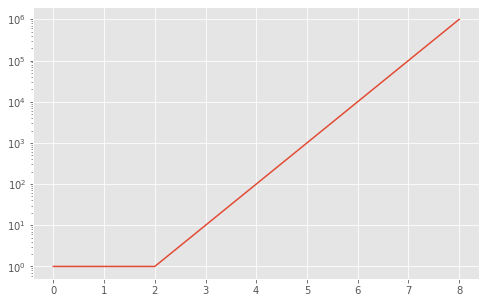

In [26]:
# use `ndarray.clip(min=1)` method!
# if using series/df, then `df.clip(lower=1)`
data=np.array([-10, 0, 1,10,10**2,10**3,10**4,10**5, 10**6])
plt.plot(data.clip(min=1))
plt.yscale('log')

## ways to split a dataset according to an attribute
- https://www.geeksforgeeks.org/split-pandas-dataframe-by-column-value/
- we can either use `query`, or better, use `groupby` and then list comprehension.

In [29]:
player_list = [['M.S.Dhoni', 36, 75, 5428000],
               ['A.B.D Villers', 38, 74, 3428000],
               ['V.Kholi', 31, 70, 8428000],
               ['S.Smith', 34, 80, 4428000],
               ['C.Gayle', 40, 100, 4528000],
               ['J.Root', 33, 72, 7028000],
               ['K.Peterson', 42, 85, 2528000]]
df = pd.DataFrame(player_list, 
                  columns = ['Name', 'Age', 
                             'Weight', 'Salary'])
df1, df2 = [gp for _, gp in df.groupby(df.Age<35)]
df1
df2

,Name,Age,Weight,Salary
0,M.S.Dhoni,36,75,5428000
1,A.B.D Villers,38,74,3428000
4,C.Gayle,40,100,4528000
6,K.Peterson,42,85,2528000


,Name,Age,Weight,Salary
2,V.Kholi,31,70,8428000
3,S.Smith,34,80,4428000
5,J.Root,33,72,7028000


## to take log but still remain to be dataframe:

In [ ]:
X.apply(lambda x: np.log(x+1)) # apply to each entry

## to check whether the df contains `na`:

In [87]:
# ------------------------------- check columns ------------------------------ #
titanic.isna().sum() # check each column
titanic.isna().mean() # show percent of missing instead

# show only those columns with missing
titanic.isna().sum()[lambda x: x>0].sort_values(ascending=False)
titanic.isna().mean()[lambda x: x>0].sort_values(ascending=False)
# ---------------------------------------------------------------------------- #

# -------------------------------- check rows -------------------------------- #
# show rows index with >=1 missing 
titanic.isna().sum(axis=1)[lambda x: x>0].sort_values(ascending=False)
# get the rows with missing values
titanic.loc[titanic.isna().sum(axis=1)[lambda x: x>0].index]
# ---------------------------------------------------------------------------- #

# drop rows/columns with any missing values
titanic.dropna(axis=0) # drop all rows with any missing values
titanic.dropna(axis=0, how='all') # drop a row with all values missing
titanic.dropna(axis=0, thresh=3) # drop a row with >=3 values missing
titanic.dropna(axis=1) # drop all columns with any missing values
titanic.dropna(axis=1, thresh=3) # drop a columns with >=3 missing values

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

deck           688
age            177
embarked         2
embark_town      2
dtype: int64

deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
dtype: float64

240    2
650    2
680    2
256    2
260    2
      ..
328    1
333    1
338    1
339    1
890    1
Length: 709, dtype: int64

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,3,male,25.0,0,0,7.0500,S,Third,man,True,NaN,Southampton,no,True
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47.0,1,1,52.5542,S,First,woman,False,D,Southampton,yes,False
872,0,1,male,33.0,0,0,5.0000,S,First,man,True,B,Southampton,no,True
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


,survived,pclass,sex,sibsp,parch,fare,class,who,adult_male,alive,alone
0,0,3,male,1,0,7.2500,Third,man,True,no,False
1,1,1,female,1,0,71.2833,First,woman,False,yes,False
2,1,3,female,0,0,7.9250,Third,woman,False,yes,True
3,1,1,female,1,0,53.1000,First,woman,False,yes,False
4,0,3,male,0,0,8.0500,Third,man,True,no,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,0,0,13.0000,Second,man,True,no,True
887,1,1,female,0,0,30.0000,First,woman,False,yes,True
888,0,3,female,1,2,23.4500,Third,woman,False,no,False
889,1,1,male,0,0,30.0000,First,man,True,yes,True


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


,total_bill,tip,sex,smoker,day,time,size,decile
0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,10.34,1.66,Male,No,Sun,Dinner,3,2
2,21.01,3.50,Male,No,Sun,Dinner,3,3
3,23.68,3.31,Male,No,Sun,Dinner,2,3
4,24.59,3.61,Female,No,Sun,Dinner,4,1
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1
241,22.67,2.00,Male,Yes,Sat,Dinner,2,3
242,17.82,1.75,Male,No,Sat,Dinner,2,2


,total_bill,tip,sex,smoker,day,time,size,decile
0,16.99,1.01,Female,No,Sun,Dinner,2,3
0,16.99,1.01,Female,No,Sun,Dinner,2,3
0,16.99,1.01,Female,No,Sun,Dinner,2,3
1,10.34,1.66,Male,No,Sun,Dinner,3,2
1,10.34,1.66,Male,No,Sun,Dinner,3,2
...,...,...,...,...,...,...,...,...
242,17.82,1.75,Male,No,Sat,Dinner,2,2
242,17.82,1.75,Male,No,Sat,Dinner,2,2
243,18.78,3.00,Female,No,Thur,Dinner,2,2
243,18.78,3.00,Female,No,Thur,Dinner,2,2


In [ ]:
# ---------------- drop those columns with >30% missing values --------------- #
threshold=0.3

# M1: manually without using dropna function
cols_to_drop = titanic.isnull().mean()[lambda x: x>threshold].index
cols_to_drop
titanic.drop(cols_to_drop, axis=1).head(2)

# M2: use dropna function directly
titanic.dropna(axis=1, thresh=int(len(titanic)*threshold)).head(2) # thresh means threshold
# ---------------------------------------------------------------------------- #

## select those records whose feature value equal to something in a list

In [82]:
towns = ['Cherbourg', 'Queenstown']
# M1: mask 
titanic[titanic['embark_town'].isin(towns)]
# M2: query 
titanic.query("embark_town in @towns") # or titanic.query(f"embark_town in {towns}")

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False
16,0,3,male,2.0,4,1,29.1250,Q,Third,child,False,NaN,Queenstown,no,False
19,1,3,female,NaN,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1,3,female,15.0,0,0,7.2250,C,Third,child,False,NaN,Cherbourg,yes,True
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False
16,0,3,male,2.0,4,1,29.1250,Q,Third,child,False,NaN,Queenstown,no,False
19,1,3,female,NaN,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1,3,female,15.0,0,0,7.2250,C,Third,child,False,NaN,Cherbourg,yes,True
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## drop/keep a specific set of columns

In [112]:
cols = ['sex', 'day', 'tip']

# --------------------------------- keep cols -------------------------------- #
# tips[cols]  # use [] directly
# tips.loc[:, cols] # bad. Use .loc 
# tips.loc[:, tips.columns.isin(cols)] # same as above. Bad. There is no need to convert the cols to mask!!!
# tips.filter(cols, axis=1) 
# ---------------------------------------------------------------------------- #

# -------------------------------- remove cols ------------------------------- #
tips[tips.columns.drop(cols)] # use pd.Index.drop 
tips.drop(cols, axis=1) # use use df.drop directly
tips.loc[:, ~tips.columns.isin(cols)] # remove those given columns. Have to use mask 
# ---------------------------------------------------------------------------- #

,total_bill,smoker,time,size,decile
0,16.99,No,Dinner,2,3
1,10.34,No,Dinner,3,2
2,21.01,No,Dinner,3,3
3,23.68,No,Dinner,2,3
4,24.59,No,Dinner,4,1
...,...,...,...,...,...
239,29.03,No,Dinner,3,3
240,27.18,Yes,Dinner,2,1
241,22.67,Yes,Dinner,2,3
242,17.82,No,Dinner,2,2


,total_bill,smoker,time,size,decile
0,16.99,No,Dinner,2,3
1,10.34,No,Dinner,3,2
2,21.01,No,Dinner,3,3
3,23.68,No,Dinner,2,3
4,24.59,No,Dinner,4,1
...,...,...,...,...,...
239,29.03,No,Dinner,3,3
240,27.18,Yes,Dinner,2,1
241,22.67,Yes,Dinner,2,3
242,17.82,No,Dinner,2,2


,total_bill,smoker,time,size,decile
0,16.99,No,Dinner,2,3
1,10.34,No,Dinner,3,2
2,21.01,No,Dinner,3,3
3,23.68,No,Dinner,2,3
4,24.59,No,Dinner,4,1
...,...,...,...,...,...
239,29.03,No,Dinner,3,3
240,27.18,Yes,Dinner,2,1
241,22.67,Yes,Dinner,2,3
242,17.82,No,Dinner,2,2


## fillna from info that is external from the df
- remember that when using groupby, we have the `.name` attribute specifying the group key!

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x

## x